# 🛰️ Sentinel-2 Super-Resolution Demo (RGB+NIR)

This notebook demonstrates a complete pipeline for enhancing the spatial resolution of Sentinel-2 images using a SwinIR deep learning model.

---

## 📦 1. Setup & Imports


In [1]:
# Standard imports
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Project imports
from utils.s2_preprocessing import resample_and_crop_sentinel2
from utils.normalize_image import normalize_sentinel_image
from super_resolution import swinir_inference
from utils.reverse_normalization import reverse_scaling

import warnings
warnings.filterwarnings("ignore")

/home/rslab2/mambaforge/envs/floodpy_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## 🌍 2. Download Sentinel-2 `.SAFE` Product

To run this demo, you'll need a Sentinel-2 Level-1C `.SAFE` archive covering your area of interest.

🛰️ **Where to Download:**

You can download free Sentinel-2 `.SAFE` products from the official **Copernicus Data Space Ecosystem**:

🔗 [https://dataspace.copernicus.eu/browser](https://dataspace.copernicus.eu/browser)

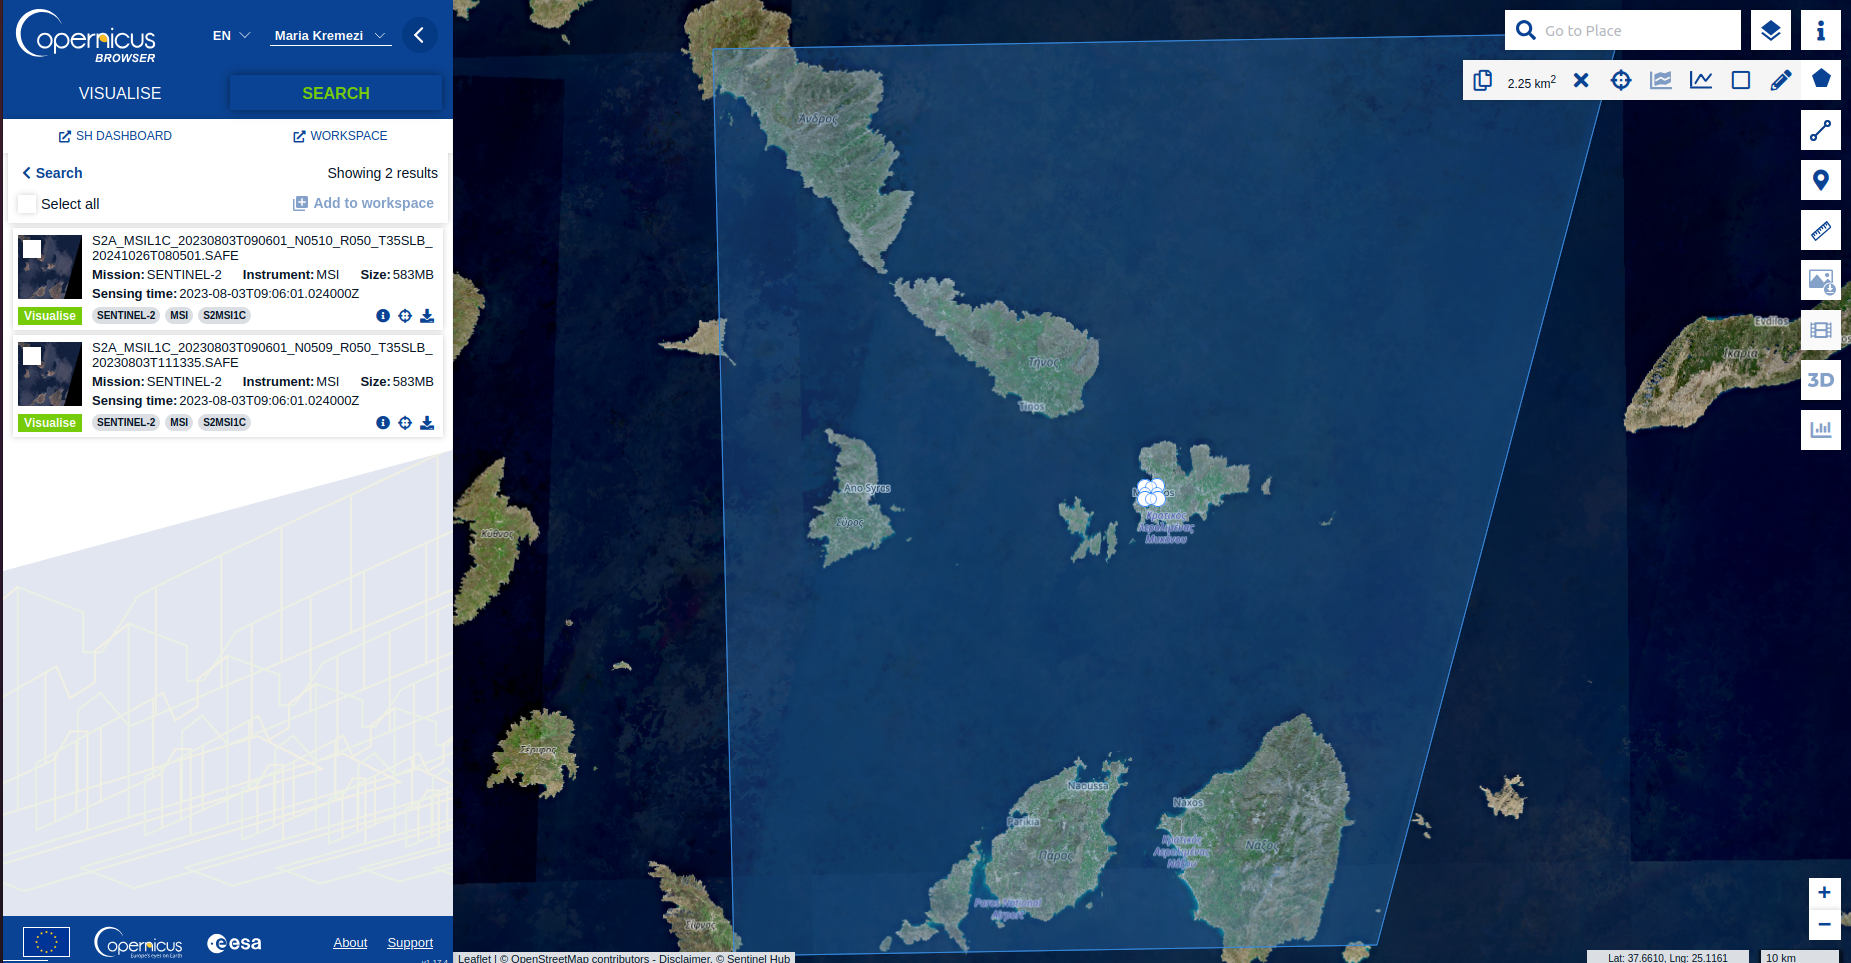

---

### 📌 Instructions:
1. Go to the link above and use the interactive map to locate your area of interest (e.g., Mykonos).
2. Select a Sentinel-2 Level-1C product (e.g., `S2A_MSIL1C_YYYYMMDDTxxxxxx_Nxxxx_Rxxx_Txxxxx_YYYYMMDDTxxxxxx.SAFE`)
3. Click **Download Product** 
4. Place the `.SAFE` folder into the `data/` directory of this repo (recommended).


---

## ⚙️ 3. Preprocessing `.SAFE` to 10m GeoTIFF


In [2]:
#Define Input/output Paths
safe_path = "data/S2A_MSIL1C_20160829T090552_N0500_R050_T35SLB_20231026T024527.SAFE"
shp_path = "data/demo_aoi_mykonos.shp"
output_path = "data/S2A_MSIL1C_20160829T090552_aoi.tif"

resample_and_crop_sentinel2(safe_path, shp_path, output_path)

[INFO] Using B02 as 10m reference: (10980, 10980)
[INFO] Stacked image shape: (10980, 10980, 13)
[INFO] Cropped image shape: (151, 151, 13)
[DONE] Output saved to: data/S2A_MSIL1C_20160829T090552_aoi.tif


## 📈 4. Load & Normalize the Sentinel-2 Image


---

We begin by reading the cropped and resampled Sentinel-2 image.  
This step allows us to extract important **geo-referencing information** (i.e., the coordinate reference system and affine transform), which we’ll reuse later to preserve geolocation across all processing stages.

Then, we **normalize** the image using precomputed scaling and histogram clipping parameters.

```

In [3]:
in_path = "/mnt/m2ssd/Super_resolution/github_repo/data/S2A_MSIL1C_20160829T090552_aoi.tif" #path where the cropped and resampled to 10m Sentinel 2 image is stored
out_path = "/mnt/m2ssd/Super_resolution/github_repo/data/S2A_MSIL1C_20160829T090552_aoi_prep.tif" # or None if you don't want to save

# Load your input image using rasterio 
with rasterio.open(in_path) as src:
    img_array = src.read().transpose(1, 2, 0)  # (H, W, C)
    gt = src.transform
    crs = src.crs

normalized = normalize_sentinel_image(in_path, out_path)

[INFO] Normalized image saved to: /mnt/m2ssd/Super_resolution/github_repo/data/S2A_MSIL1C_20160829T090552_aoi_prep.tif


## ✨ 5. Super-Resolution Inference

In [4]:
sr_image = swinir_inference(
    image_array=normalized,
    geo_transform=gt,
    crs=crs,
    save_path="/mnt/m2ssd/Super_resolution/github_repo/data/S2A_MSIL1C_20160829T090552_aoi_super.tif"  # or None if you don't want to save
)

## 🔁 6. Reverse Scaling


In [5]:
from utils.reverse_normalization import reverse_scaling

sr_output_path = "data/S2A_MSIL1C_20160829T090552_aoi_super_postprocessed.tif"

# Reverse the scaling
final_image = reverse_scaling(
    sr_image,
    geo_transform=gt,
    crs=crs,
    save_path= sr_output_path # or None to skip saving
)

## 🖼️ 7. Visualization

### Notes
- Stretching: All bands are histogram-stretched to improve contrast.
- Slider Tool: Powered by `jupyter-compare-view`, allowing interactive side-by-side inspection.
- The original 10 m image is displayed on the **left**, and the 2.5 m super-resolved image is shown on the **right**.


## RGB Super-Resolution Comparison

The following visualization compares the **original 10 m RGB composite** of the Sentinel-2 image with the **super-resolved 2.5 m output** produced by the SwinIR model.

> Slide the handle to see the improvement in spatial detail and sharpness.



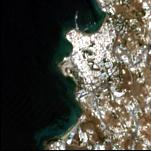
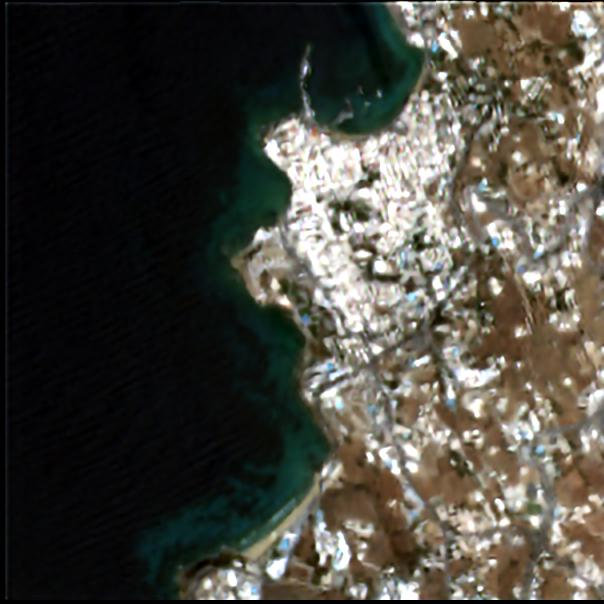

In [24]:
from jupyter_compare_view import compare

def to_uint8_stretch(img, pmin=2, pmax=98):
    """Apply 2% linear stretch and convert to uint8"""
    img = img.astype(np.float32)
    stretched = np.zeros_like(img)
    for b in range(img.shape[2]):
        low = np.percentile(img[:, :, b], pmin)
        high = np.percentile(img[:, :, b], pmax)
        stretched[:, :, b] = np.clip((img[:, :, b] - low) / (high - low), 0, 1)
    return (stretched * 255).astype(np.uint8)

# Select correct bands: Red = 3, Green = 2, Blue = 1 → shift to 0-based index: [2, 1, 0]
# Input image: original 10m resolution
rgb_input = to_uint8_stretch(img_array[:, :, [3, 2, 1]])

# Output image: already in [B, G, R, NIR] order
rgb_output = to_uint8_stretch(final_image[:, :, [2, 1, 0]])

compare(
    rgb_input,
    rgb_output,
    start_mode="horizontal",
    start_slider_pos=0.5,
    height=1000
)


## NIR Band Super-Resolution

This comparison focuses on the **Near-Infrared (NIR) band**. Super-resolution enhances the spatial resolution of the NIR band from 10 m to 2.5 m.





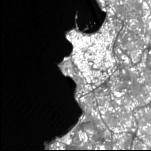
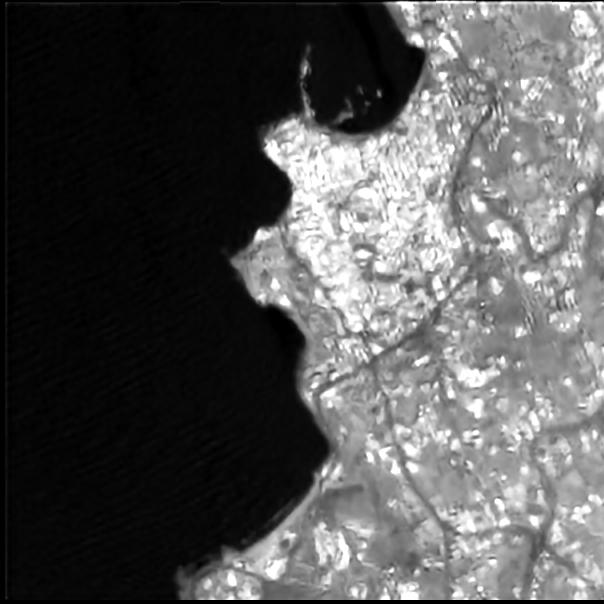

In [25]:
# Apply 2% stretch to NIR band and scale to uint8 for visualization
def stretch_nir(band, pmin=2, pmax=98):
    band = band.astype(np.float32)
    low = np.percentile(band, pmin)
    high = np.percentile(band, pmax)
    stretched = np.clip((band - low) / (high - low), 0, 1)
    return (stretched * 255).astype(np.uint8)

nir_input = stretch_nir(img_array[:, :, 7])
nir_output = stretch_nir(final_image[:, :, 3])

compare(
    nir_input,
    nir_output,
    cmap='gray',
    start_mode="horizontal",
    start_slider_pos=0.5,
    height=1000  # height in pixels, increase if needed
)
